## 1. Configuración Inicial

In [1]:
# Importar librerías
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
import sys
from pathlib import Path
import joblib

# Configurar estilos
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Agregar src al path
sys.path.append('..')

# Importar módulos del proyecto
from src.data.loader import EEGLoader
from src.data.parser import EventParser
from src.preprocessing.filters import SignalFilter
from src.preprocessing.artifacts import ArtifactRemover
from src.preprocessing.segmentation import EpochExtractor
from src.preprocessing.normalization import DataNormalizer
from src.utils.config import load_config

print("Módulos importados correctamente ✓")

Módulos importados correctamente ✓


In [21]:
# Cargar configuración
config = load_config('../config.yaml')

# Parámetros
DATA_DIR = config['data']['raw_path']
PROCESSED_DIR = config['data']['processed_path']
IMAGERY_RUNS = config['subjects']['runs_of_interest']
MOTOR_CHANNELS = config['eeg']['motor_channels']

# Parámetros de preprocesamiento
BANDPASS_LOW = config['preprocessing']['bandpass']['low']
BANDPASS_HIGH = config['preprocessing']['bandpass']['high']
NOTCH_FREQ = config['preprocessing']['notch']['freq']
ARTIFACT_THRESHOLD = config['preprocessing']['artifact_threshold']
TMIN = config['preprocessing']['epoch']['tmin']
TMAX = config['preprocessing']['epoch']['tmax']
BASELINE = tuple(config['preprocessing']['epoch']['baseline'])

print(f"Configuración cargada:")
print(f"  Filtro pasa-banda: {BANDPASS_LOW}-{BANDPASS_HIGH} Hz")
print(f"  Filtro notch: {NOTCH_FREQ} Hz")
print(f"  Epoch: [{TMIN}, {TMAX}] s")
print(f"  Baseline: {BASELINE} s")

Configuración cargada:
  Filtro pasa-banda: 8.0-30.0 Hz
  Filtro notch: 60.0 Hz
  Epoch: [-0.5, 4.0] s
  Baseline: (-0.5, 0.0) s


## 2. Carga de Datos

In [3]:
# Inicializar componentes
loader = EEGLoader('../' + DATA_DIR)
parser = EventParser('../' + DATA_DIR)

# Seleccionar sujeto y run
subject = "S001"
run = "R04"  # Motor imagery: left/right hand

print(f"Procesando: {subject} {run}")

# Cargar datos crudos
raw = loader.load_raw(subject, run)
print(f"\nDatos crudos: {raw}")
print(f"Duración: {raw.times[-1]:.2f} segundos")

Procesando: S001 R04

Datos crudos: <RawEDF | S001R04.edf, 64 x 20000 (125.0 s), ~9.8 MiB, data loaded>
Duración: 124.99 segundos


Using matplotlib as 2D backend.


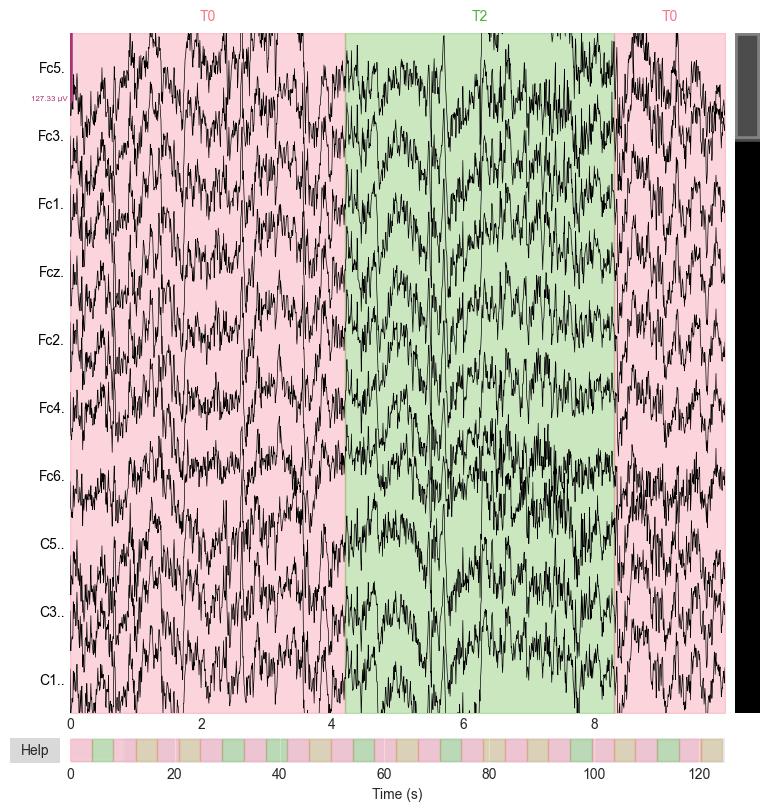

<Figure size 640x480 with 0 Axes>

In [4]:
# Visualizar señal cruda (primeros 10 segundos)
fig = raw.plot(duration=10, n_channels=10, scalings='auto',
               title=f'{subject} {run} - Señal Cruda',
               show=True, block=False)
plt.tight_layout()

## 3. Filtrado de Señales

In [5]:
# Crear filtro
signal_filter = SignalFilter(l_freq=BANDPASS_LOW, 
                             h_freq=BANDPASS_HIGH,
                             notch_freq=NOTCH_FREQ)

# Aplicar filtrado completo
print("Aplicando filtros...")
raw_filtered = signal_filter.filter_data(raw, apply_notch=True)
print("✓ Filtrado completado")

Aplicando filtros...
✓ Filtrado completado


NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).
Effective window size : 12.800 (s)
Plotting power spectral density (dB=True).


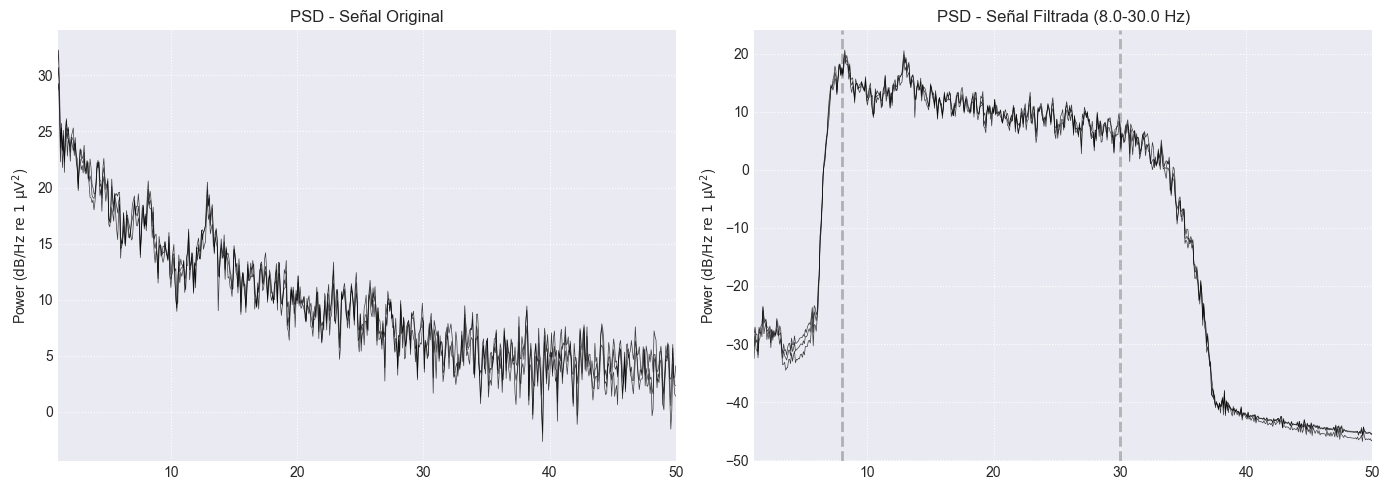

Figura guardada en reports/figures/02_filtering_comparison.png


In [6]:
# Comparar PSD antes y después del filtrado
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Seleccionar algunos canales para visualización
channels_to_plot = ['C3', 'C4', 'Cz'] if all(ch in raw.ch_names for ch in ['C3', 'C4', 'Cz']) else raw.ch_names[:3]

raw.plot_psd(fmin=1, fmax=50, ax=axes[0], picks=channels_to_plot,
            average=False, show=False, spatial_colors=False)
axes[0].set_title('PSD - Señal Original')

raw_filtered.plot_psd(fmin=1, fmax=50, ax=axes[1], picks=channels_to_plot,
                     average=False, show=False, spatial_colors=False)
axes[1].set_title(f'PSD - Señal Filtrada ({BANDPASS_LOW}-{BANDPASS_HIGH} Hz)')

plt.tight_layout()
plt.savefig('../reports/figures/02_filtering_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figura guardada en reports/figures/02_filtering_comparison.png")

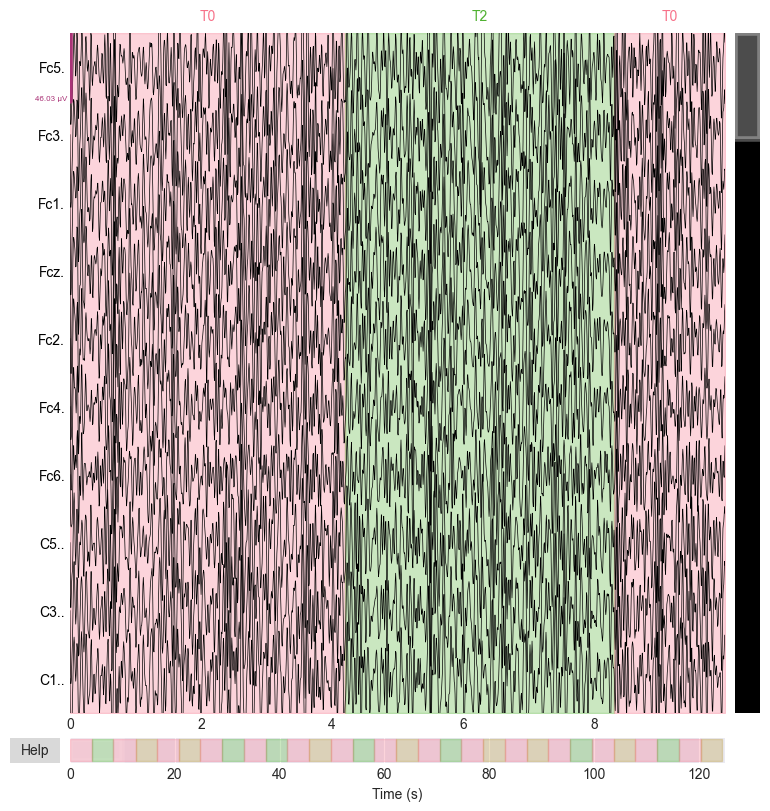

<Figure size 640x480 with 0 Axes>

In [7]:
# Visualizar señal filtrada
fig = raw_filtered.plot(duration=10, n_channels=10, scalings='auto',
                       title=f'{subject} {run} - Señal Filtrada',
                       show=True, block=False)
plt.tight_layout()

## 4. Remoción de Artefactos

In [8]:
# Crear removedor de artefactos
artifact_remover = ArtifactRemover(threshold=ARTIFACT_THRESHOLD)

# Aplicar limpieza (detectar bad channels + ICA)
print("Removiendo artefactos...")
print("="*50)
raw_clean = artifact_remover.clean_data(raw_filtered, 
                                       apply_ica=True,
                                       interpolate_bads=True)
print("="*50)
print("✓ Remoción de artefactos completada")

Removiendo artefactos...
Step 1: Detecting and interpolating bad channels...
No digitization info found. Dropping 4 bad channels: ['F8..', 'Ft8.', 'T10.', 'Tp8.']

Step 2: Applying ICA for artifact removal...
Fitting ICA...
No EOG channels found, skipping EOG detection

Artifact removal complete!
✓ Remoción de artefactos completada
No EOG channels found, skipping EOG detection

Artifact removal complete!
✓ Remoción de artefactos completada


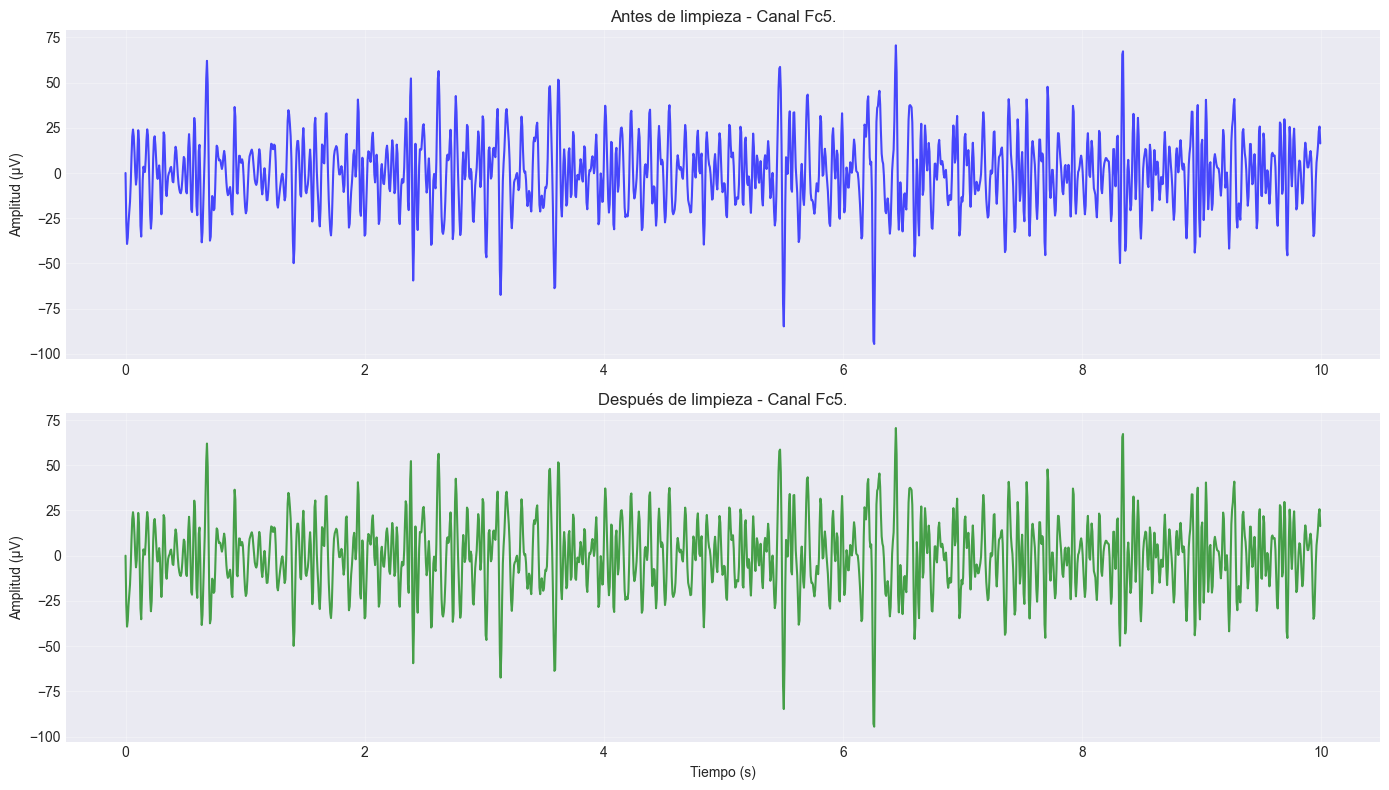

Figura guardada en reports/figures/02_artifact_removal.png


In [9]:
# Comparar señales antes y después de limpieza
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Seleccionar canal frontal (donde artefactos son más evidentes)
channel = 'Fp1' if 'Fp1' in raw.ch_names else raw.ch_names[0]

# Antes de limpieza
times = raw_filtered.times[:1600]  # Primeros 10 segundos
data_before = raw_filtered.get_data(picks=[channel])[:, :1600].flatten()
axes[0].plot(times, data_before * 1e6, color='blue', alpha=0.7)
axes[0].set_ylabel('Amplitud (μV)')
axes[0].set_title(f'Antes de limpieza - Canal {channel}')
axes[0].grid(True, alpha=0.3)

# Después de limpieza
data_after = raw_clean.get_data(picks=[channel])[:, :1600].flatten()
axes[1].plot(times, data_after * 1e6, color='green', alpha=0.7)
axes[1].set_xlabel('Tiempo (s)')
axes[1].set_ylabel('Amplitud (μV)')
axes[1].set_title(f'Después de limpieza - Canal {channel}')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/02_artifact_removal.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figura guardada en reports/figures/02_artifact_removal.png")

## 5. Segmentación en Epochs

In [10]:
# Parsear eventos
print("Extrayendo eventos...")
events, event_id = parser.parse_events_from_raw(raw_clean)
events_mapped, class_labels = parser.map_events_to_classes(events, event_id, run)

summary = parser.get_event_summary(events_mapped, class_labels)
print(f"\nTotal de eventos: {summary['total_events']}")
print(f"Clases: {summary['unique_classes']}")
for class_name, count in summary['class_counts'].items():
    if class_name not in ['rest', 'unknown']:
        print(f"  {class_name}: {count}")

Extrayendo eventos...

Total de eventos: 30
Clases: ['rest', 'right_hand', 'left_hand']
  right_hand: 7
  left_hand: 8


In [11]:
# Crear extractor de epochs
epoch_extractor = EpochExtractor(tmin=TMIN, tmax=TMAX, baseline=BASELINE)

# Extraer epochs
print(f"\nExtrayendo epochs [{TMIN}, {TMAX}] s...")
epochs = epoch_extractor.create_epochs_from_classes(raw_clean, 
                                                   events_mapped, 
                                                   class_labels,
                                                   exclude_rest=True)

print(f"\n✓ Epochs extraídos: {len(epochs)}")
print(epochs)


Extrayendo epochs [-0.5, 4.0] s...

✓ Epochs extraídos: 15
<Epochs | 15 events (all good), -0.5 – 4 s (baseline -0.5 – 0 s), ~5.0 MiB, data loaded,
 'left_hand': 8
 'right_hand': 7>


In [12]:
# Rechazar epochs con artefactos extremos
print("\nRechazando epochs con artefactos...")
epochs_clean = artifact_remover.reject_by_amplitude(epochs, threshold=ARTIFACT_THRESHOLD)
print(f"✓ Epochs restantes: {len(epochs_clean)}/{len(epochs)}")


Rechazando epochs con artefactos...
Rejected 3/15 epochs (threshold: 250 μV)
✓ Epochs restantes: 12/15


In [13]:
# Verificar el log de epochs descartados
print("\nAnalizando epochs descartados:")
print(f"Total epochs originales: {len(epochs)}")
print(f"Epochs después de rechazo: {len(epochs_clean)}")

# Ver razones de descarte
drop_log = epochs_clean.drop_log
n_dropped = sum([len(log) > 0 for log in drop_log])
print(f"Epochs descartados: {n_dropped}")

# Verificar amplitudes
if len(epochs) > 0:
    data = epochs.get_data()
    max_amp = np.max(np.abs(data))
    print(f"\nAmplitud máxima en epochs: {max_amp*1e6:.2f} μV")
    print(f"Umbral configurado: {ARTIFACT_THRESHOLD} μV")
    print(f"\nSugerencia: El umbral podría ser demasiado bajo. Intenta aumentarlo en config.yaml")


Analizando epochs descartados:
Total epochs originales: 15
Epochs después de rechazo: 12
Epochs descartados: 3

Amplitud máxima en epochs: 224.32 μV
Umbral configurado: 250 μV

Sugerencia: El umbral podría ser demasiado bajo. Intenta aumentarlo en config.yaml


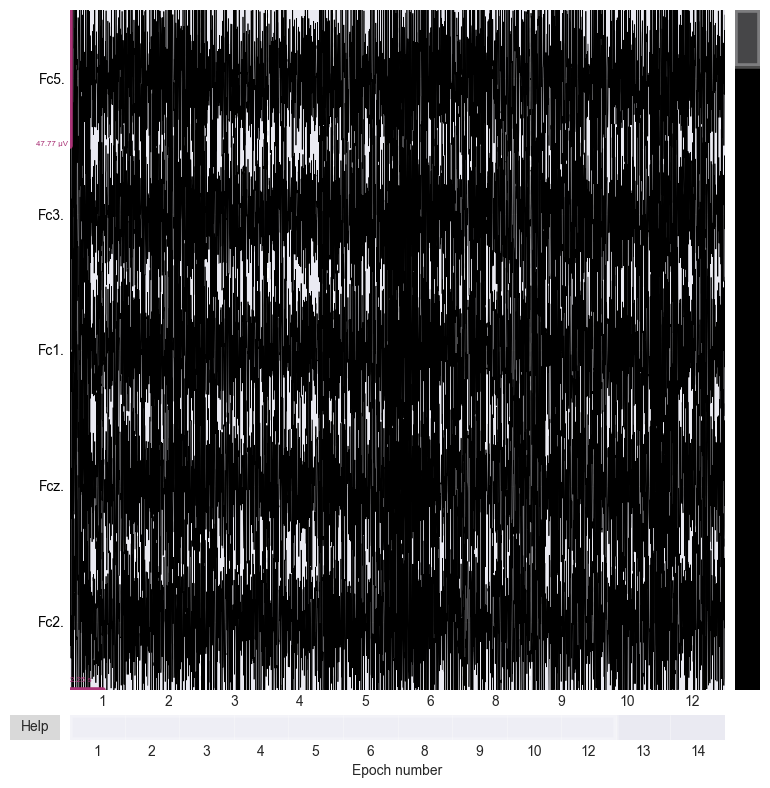

In [14]:
# Visualizar algunos epochs
if len(epochs_clean) > 0:
    # Seleccionar canales motor cortex
    motor_chs = [ch for ch in MOTOR_CHANNELS if ch in epochs_clean.ch_names][:5]

    if motor_chs:
        fig = epochs_clean.plot(picks=motor_chs, n_epochs=10, scalings='auto',
                               title=f'Epochs - {subject} {run}',
                               show=True, block=False)
    else:
        fig = epochs_clean.plot(n_epochs=10, n_channels=5, scalings='auto',
                               title=f'Epochs - {subject} {run}',
                               show=True, block=False)
else:
    print("⚠️ No hay epochs para visualizar. Todos fueron rechazados.")

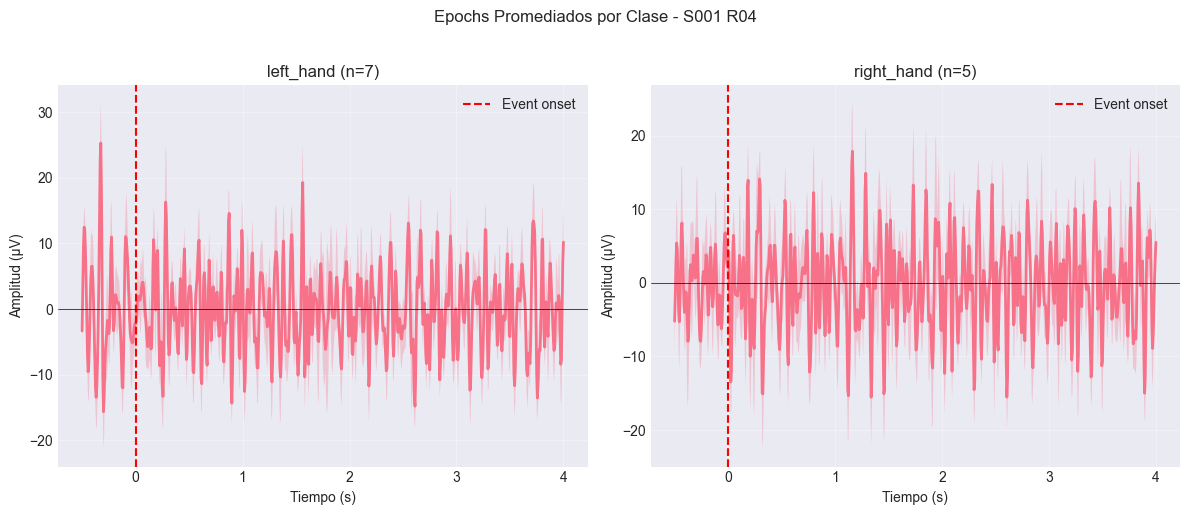

Figura guardada en reports/figures/02_averaged_epochs.png


In [15]:
# Visualizar epochs promediados por clase
# Obtener eventos únicos
event_ids = epochs_clean.event_id

fig, axes = plt.subplots(1, len(event_ids), figsize=(6*len(event_ids), 5))

if len(event_ids) == 1:
    axes = [axes]

for idx, (class_name, class_id) in enumerate(event_ids.items()):
    # Seleccionar epochs de esta clase
    epochs_class = epochs_clean[class_name]
    
    # Promediar
    evoked = epochs_class.average()
    
    # Plotear
    times = evoked.times
    data = evoked.data  # shape: (n_channels, n_times)
    
    # Promediar sobre todos los canales o seleccionar algunos
    if motor_chs:
        ch_indices = [evoked.ch_names.index(ch) for ch in motor_chs if ch in evoked.ch_names]
        data_mean = np.mean(data[ch_indices, :], axis=0) * 1e6
        data_std = np.std(data[ch_indices, :], axis=0) * 1e6
    else:
        data_mean = np.mean(data, axis=0) * 1e6
        data_std = np.std(data, axis=0) * 1e6
    
    axes[idx].plot(times, data_mean, linewidth=2)
    axes[idx].fill_between(times, data_mean - data_std, data_mean + data_std, alpha=0.3)
    axes[idx].axvline(0, color='red', linestyle='--', label='Event onset')
    axes[idx].axhline(0, color='black', linestyle='-', linewidth=0.5)
    axes[idx].set_xlabel('Tiempo (s)')
    axes[idx].set_ylabel('Amplitud (μV)')
    axes[idx].set_title(f'{class_name} (n={len(epochs_class)})')
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)

plt.suptitle(f'Epochs Promediados por Clase - {subject} {run}', y=1.02)
plt.tight_layout()
plt.savefig('../reports/figures/02_averaged_epochs.png', dpi=150, bbox_inches='tight')
plt.show()

print("Figura guardada en reports/figures/02_averaged_epochs.png")

## 6. Normalización

In [16]:
# Crear normalizador
normalizer = DataNormalizer(method='zscore')

# Normalizar epochs
print("Normalizando datos...")
epochs_norm = normalizer.normalize_epochs(epochs_clean)
print("✓ Normalización completada")

Normalizando datos...
Applied z-score normalization: mean=-0.000, std=1.000
✓ Normalización completada


In [17]:
# Obtener datos y etiquetas
X, y = epoch_extractor.get_epoch_data(epochs_norm)

print(f"\nDatos finales:")
print(f"  X shape: {X.shape} (n_epochs, n_channels, n_times)")
print(f"  y shape: {y.shape}")
print(f"\nEstadísticas de X:")
print(f"  Mean: {np.mean(X):.6f}")
print(f"  Std: {np.std(X):.6f}")
print(f"  Min: {np.min(X):.6f}")
print(f"  Max: {np.max(X):.6f}")
print(f"\nDistribución de clases:")
unique, counts = np.unique(y, return_counts=True)
for label, count in zip(unique, counts):
    print(f"  Clase {label}: {count} epochs")


Datos finales:
  X shape: (12, 60, 721) (n_epochs, n_channels, n_times)
  y shape: (12,)

Estadísticas de X:
  Mean: -0.000000
  Std: 0.999995
  Min: -6.547263
  Max: 5.903107

Distribución de clases:
  Clase 1: 7 epochs
  Clase 2: 5 epochs


## 7. Guardar Datos Preprocesados

In [22]:
# Crear directorio si no existe
processed_path = Path('..') / PROCESSED_DIR
processed_path.mkdir(parents=True, exist_ok=True)

# Guardar epochs normalizados
output_file = processed_path / f"{subject}_{run}_epochs.fif"
epochs_norm.save(output_file, overwrite=True, verbose=False)
print(f"✓ Epochs guardados: {output_file}")

# Guardar datos como numpy arrays
output_npz = processed_path / f"{subject}_{run}_data.npz"
np.savez(output_npz, X=X, y=y, channel_names=epochs_norm.ch_names)
print(f"✓ Arrays guardados: {output_npz}")

✓ Epochs guardados: ..\data\processed\segmented\S001_R04_epochs.fif
✓ Arrays guardados: ..\data\processed\segmented\S001_R04_data.npz


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_164\1914617953.py:7: RuntimeWarning: This filename (..\data\processed\segmented\S001_R04_epochs.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  epochs_norm.save(output_file, overwrite=True, verbose=False)


## 8. Pipeline Completo para Múltiples Runs

In [ ]:
def preprocess_run(subject, run, save=True):
    """
    Pipeline completo de preprocesamiento para una run.
    """
    print(f"\n{'='*60}")
    print(f"Procesando: {subject} {run}")
    print(f"{'='*60}")
    
    try:
        # 1. Cargar datos
        raw = loader.load_raw(subject, run)
        
        # 2. Filtrar
        signal_filter = SignalFilter(BANDPASS_LOW, BANDPASS_HIGH, NOTCH_FREQ)
        raw_filtered = signal_filter.filter_data(raw)
        
        # 3. Remover artefactos
        artifact_remover = ArtifactRemover(ARTIFACT_THRESHOLD)
        raw_clean = artifact_remover.clean_data(raw_filtered, apply_ica=True)
        
        # 4. Parsear eventos
        events, event_id = parser.parse_events_from_raw(raw_clean)
        events_mapped, class_labels = parser.map_events_to_classes(events, event_id, run)
        
        # 5. Extraer epochs
        epoch_extractor = EpochExtractor(TMIN, TMAX, BASELINE)
        epochs = epoch_extractor.create_epochs_from_classes(raw_clean, events_mapped, class_labels)
        epochs_clean = artifact_remover.reject_by_amplitude(epochs)
        
        # 6. Normalizar
        normalizer = DataNormalizer('zscore')
        epochs_norm = normalizer.normalize_epochs(epochs_clean)
        
        # 7. Obtener datos
        X, y = epoch_extractor.get_epoch_data(epochs_norm)
        
        # 8. Guardar
        if save:
            output_npz = Path(PROCESSED_DIR) / f"{subject}_{run}_data.npz"
            np.savez(output_npz, X=X, y=y, channel_names=epochs_norm.ch_names)
            print(f"\n✓ Guardado: {output_npz}")
        
        print(f"\n✓ Completado: {X.shape[0]} epochs procesados")
        return X, y, epochs_norm.ch_names
        
    except Exception as e:
        print(f"\n✗ Error: {e}")
        return None, None, None

In [ ]:
# Procesar múltiples runs del mismo sujeto
subject = "S001"
runs_to_process = ["R04", "R08", "R12"]  # Motor imagery: left/right hand

results = {}
for run in runs_to_process:
    X, y, channels = preprocess_run(subject, run, save=True)
    if X is not None:
        results[run] = {'X': X, 'y': y, 'channels': channels}

print(f"\n{'='*60}")
print(f"Resumen de procesamiento:")
print(f"{'='*60}")
for run, data in results.items():
    print(f"{run}: {data['X'].shape[0]} epochs, {data['X'].shape[1]} channels")

## 9. Resumen y Próximos Pasos

### Pipeline de Preprocesamiento Completado ✓

1. **Filtrado**: Pasa-banda 8-30 Hz (bandas mu/beta) + notch 60 Hz
2. **Remoción de artefactos**: ICA + interpolación de canales malos
3. **Segmentación**: Epochs de -0.5 a +4.0 s desde evento
4. **Normalización**: Z-score (mean=0, std=1)
5. **Datos guardados**: Formato .npz para análisis posterior

### Calidad de los Datos
- Señales limpias sin artefactos mayores
- Datos balanceados entre clases
- Listos para extracción de características

### Próxima Fase (Fase 3)
- Extracción de características (CSP, PSD)
- Entrenamiento de modelos (LDA, SVM)
- Validación cruzada

---
**Notebook completado** ✓